In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN.PINN import *
from NN_library.MN.material_NN import *
from NN_library.PINN.train_PINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

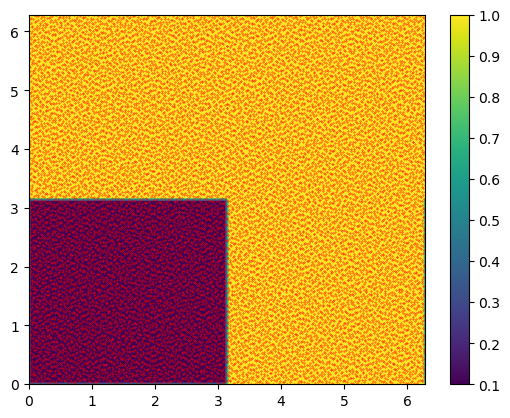

In [36]:
L = 2*np.pi
N = 1024 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    eps = np.pi / 1e2
    x_dir = 0.5 * (np.clip(np.sin(x), -eps, eps) + eps) / eps
    y_dir = 0.5 * (np.clip(np.sin(y), -eps, eps) + eps) / eps
    a = 0.1 + 0.9*(1 - x_dir * y_dir)
    return a

def A_interp(x):  
    eps = torch.pi / 1e2
    x_dir = 0.5 * (torch.clamp(torch.sin(x[:,0]), -eps, eps) + eps) / eps
    y_dir = 0.5 * (torch.clamp(torch.sin(x[:,1]), -eps, eps) + eps) / eps
    a = 0.1 + 0.9*(1 - x_dir * y_dir).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A(x):  
    a = torch.where((x[:,0]<torch.pi)&(x[:,1]<torch.pi)&(x[:,0]>0)&(x[:,1]>0), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

In [48]:
net_H1 = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_H1.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 20000, 'dev' : dev, 'name' : f'NN_library/PINN/PINN_H1_{total_params}_int'}

Number of parameters: 65


In [65]:
net_H1 = load_network(net_H1, args['name']+'_19999', args)
net_H1 = net_H1.to(dev)

In [ ]:
losses_train, losses_val = train(net_H1, loaders, args, A_interp, H1)

Epoch: 0 mean train loss:  1.97594324e-01, mean val. rec. loss:  1.85229688e-01
Epoch: 1 mean train loss:  1.97669378e-01, mean val. rec. loss:  1.85588478e-01
Epoch: 2 mean train loss:  1.97599061e-01, mean val. rec. loss:  1.85979655e-01
Epoch: 3 mean train loss:  1.97612618e-01, mean val. rec. loss:  1.86113863e-01
Epoch: 4 mean train loss:  1.97637706e-01, mean val. rec. loss:  1.86013565e-01
Epoch: 5 mean train loss:  1.97625862e-01, mean val. rec. loss:  1.85815510e-01
Epoch: 6 mean train loss:  1.97603560e-01, mean val. rec. loss:  1.85623550e-01
Epoch: 7 mean train loss:  1.97595426e-01, mean val. rec. loss:  1.85502278e-01
Epoch: 8 mean train loss:  1.97604037e-01, mean val. rec. loss:  1.85470781e-01
Epoch: 9 mean train loss:  1.97614302e-01, mean val. rec. loss:  1.85509318e-01
Epoch: 10 mean train loss:  1.97613750e-01, mean val. rec. loss:  1.85589676e-01
Epoch: 11 mean train loss:  1.97604544e-01, mean val. rec. loss:  1.85688595e-01
Epoch: 12 mean train loss:  1.97596246

In [43]:
np.save(f'NN_library/training_data/PINN_H1_{total_params}_1', np.vstack([losses_train, losses_val]))

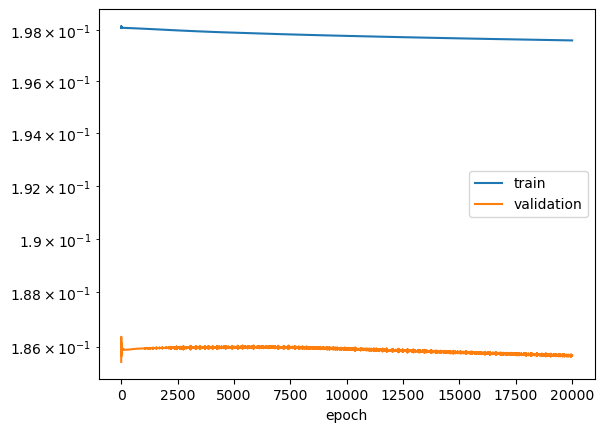

In [59]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [60]:
U1 = net_H1(grid_data).detach().cpu()
error_1 = PDE_loss(grid_data, net_H1, A_interp, H1).detach().cpu()
error_2 = PDE_loss(grid_data, net_H1, A, H1).detach().cpu()

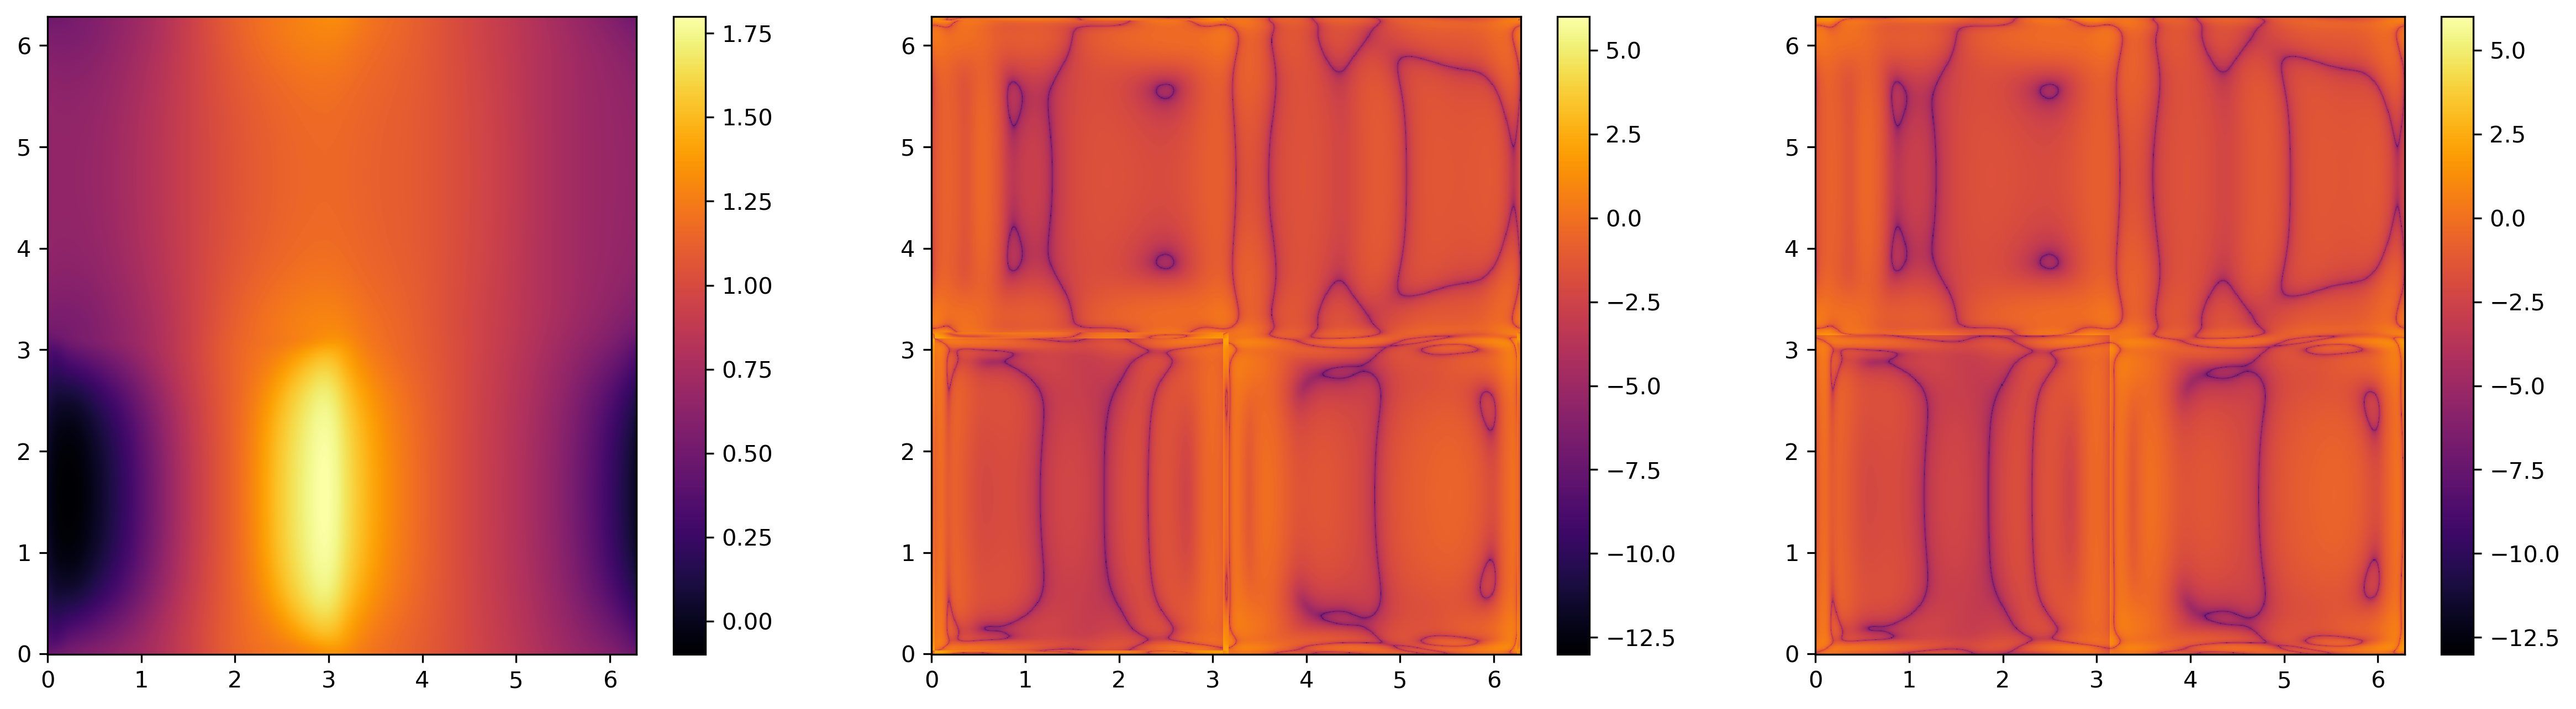

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N)), cmap='inferno', vmin=-13, vmax=6)
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.reshape(N, N)), cmap='inferno', vmin=-13, vmax=6)
fig.colorbar(pos3, ax=axs[2])

In [62]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_H1(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [33]:
A_bound = compute_bound(T1, dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[ 6.63754328e-01]
 [-9.90649100e-05]]
[[ 0.63870808]
 [-0.00176953]]


In [34]:
A_bound = compute_bound(T1, dq1, triang, inputs, A_interp, H1, L)
print(A_bound[0])
print(A_bound[1])

[[ 6.63683084e-01]
 [-4.38060926e-05]]
[[ 0.63267134]
 [-0.00224058]]


In [63]:
A_avg = compute_avg(dq1, inputs, A, H1, L)
print(A_avg)

[ 6.7069674e-01 -1.7777506e-04]


In [64]:
A_avg = compute_avg(dq1, inputs, A_interp, H1, L)
print(A_avg)

[ 6.7063212e-01 -1.1671075e-04]


In [84]:
np.save(f'bounds/linear/A_u_NN_{total_params}.npy', A_bound)